In [1]:
import numpy as np
from PIL import Image
from skimage import draw
import random
from pathlib import Path

def create_image(path, img_size, min_radius):
    path.parent.mkdir( parents=True, exist_ok=True )
    
    arr = np.zeros((img_size, img_size)).astype(np.uint8)
    center_x = random.randint(min_radius, (img_size-min_radius))
    center_y = random.randint(min_radius, (img_size-min_radius))
    max_radius = min(center_x, center_y, img_size - center_x, img_size - center_y)
    radius = random.randint(min_radius, max_radius)

    row_indxs, column_idxs = draw.ellipse(center_x, center_y, radius, radius, shape=arr.shape)
    
    arr[row_indxs, column_idxs] = 255

    im = Image.fromarray(arr)
    im.save(path)

def create_images(data_root_path, train_num, val_num, test_num, img_size=640, min_radius=10):
    data_root_path = Path(data_root_path)
    
    for i in range(train_num):
        create_image(data_root_path / 'train' / 'images' / f'img_{i}.png', img_size, min_radius)
        
    for i in range(val_num):
        create_image(data_root_path / 'val' / 'images' / f'img_{i}.png', img_size, min_radius)
        
    for i in range(test_num):
        create_image(data_root_path / 'test' / 'images' / f'img_{i}.png', img_size, min_radius)

create_images('datasets', train_num=120, val_num=40, test_num=40, img_size=120, min_radius=10)

In [2]:
from rasterio import features

def create_label(image_path, label_path):
    arr = np.asarray(Image.open(image_path))

    # There may be a better way to do it, but this is what I have found so far
    cords = list(features.shapes(arr, mask=(arr >0)))[0][0]['coordinates'][0]
    label_line = '0 ' + ' '.join([f'{int(cord[0])/arr.shape[0]} {int(cord[1])/arr.shape[1]}' for cord in cords])

    label_path.parent.mkdir( parents=True, exist_ok=True )
    with label_path.open('w') as f:
        f.write(label_line)

for images_dir_path in [Path(f'datasets/{x}/images') for x in ['train', 'val', 'test']]:
    for img_path in images_dir_path.iterdir():
        label_path = img_path.parent.parent / 'labels' / f'{img_path.stem}.txt'
        label_line = create_label(img_path, label_path)

In [3]:
yaml_content = f'''
train: train/images
val: val/images
test: test/images

names: ['circle']
    '''
    
with Path('data.yaml').open('w') as f:
    f.write(yaml_content)

In [4]:
from ultralytics import YOLO

model = YOLO("yolov8n-seg.pt")

results = model.train(
        batch=8,
        device="cpu",
        data="data.yaml",
        epochs=7,
        imgsz=120,
    )

100%|██████████| 6.73M/6.73M [00:00<00:00, 10.7MB/s]


Ultralytics YOLOv8.1.29 🚀 Python-3.8.18 torch-2.2.1+cpu CPU (AMD Ryzen 9 5950X 16-Core Processor)
engine\trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=data.yaml, epochs=7, time=None, patience=100, batch=8, imgsz=120, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

train: Scanning E:\硕士文件\TUE\tue-5ARIP10-Q3 Team project\YOLO\ultralytics-main\datasets\train\labels... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<00:00, 1935.47it/s]

train: New cache created: E:\硕士文件\TUE\tue-5ARIP10-Q3 Team project\YOLO\ultralytics-main\datasets\train\labels.cache



val: Scanning E:\硕士文件\TUE\tue-5ARIP10-Q3 Team project\YOLO\ultralytics-main\datasets\val\labels... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<00:00, 1905.03it/s]

val: New cache created: E:\硕士文件\TUE\tue-5ARIP10-Q3 Team project\YOLO\ultralytics-main\datasets\val\labels.cache


Plotting labels to runs\segment\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 0 dataloader workers
Logging results to runs\segment\train
Starting training for 7 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/7         0G      1.061     0.9487      3.016     0.9341         17        128: 100%|██████████| 15/15 [00:02<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.45it/s]

                   all         40         40     0.0183          1     0.0896     0.0652     0.0183          1     0.0997     0.0714



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/7         0G     0.7159     0.5315      1.441     0.8711         19        128: 100%|██████████| 15/15 [00:02<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.68it/s]

                   all         40         40          1      0.205      0.722      0.569          1      0.205      0.698      0.498



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/7         0G     0.7455     0.5762     0.8361     0.8717         16        128: 100%|██████████| 15/15 [00:02<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.06it/s]

                   all         40         40          1      0.968      0.995      0.807          1      0.968      0.995      0.708



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/7         0G     0.7035     0.4508     0.7235     0.8825         12        128: 100%|██████████| 15/15 [00:02<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.62it/s]

                   all         40         40      0.992          1      0.995      0.886      0.992          1      0.995      0.724



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/7         0G     0.6081     0.3779     0.6892     0.8483         11        128: 100%|██████████| 15/15 [00:02<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.09it/s]

                   all         40         40       0.99          1      0.995      0.865       0.99          1      0.995      0.721



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        6/7         0G     0.6159     0.3824     0.6743     0.8972         19        128: 100%|██████████| 15/15 [00:02<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.35it/s]

                   all         40         40      0.996          1      0.995      0.872      0.996          1      0.995      0.706



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        7/7         0G     0.5898     0.3139      0.672     0.8559         14        128: 100%|██████████| 15/15 [00:02<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.92it/s]

                   all         40         40      0.998          1      0.995      0.905      0.998          1      0.995      0.738



7 epochs completed in 0.006 hours.
Optimizer stripped from runs\segment\train\weights\last.pt, 6.7MB
Optimizer stripped from runs\segment\train\weights\best.pt, 6.7MB

Validating runs\segment\train\weights\best.pt...
Ultralytics YOLOv8.1.29 🚀 Python-3.8.18 torch-2.2.1+cpu CPU (AMD Ryzen 9 5950X 16-Core Processor)
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.98it/s]


                   all         40         40      0.998          1      0.995      0.905      0.998          1      0.995      0.738
Speed: 0.1ms preprocess, 3.8ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\segment\train


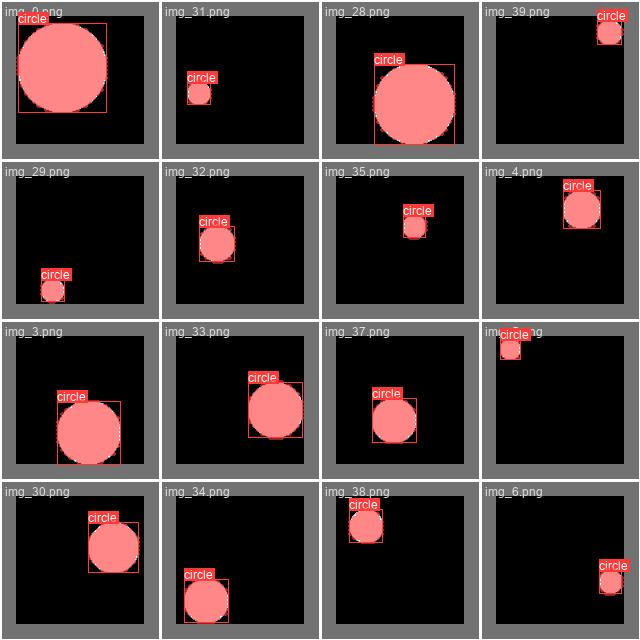

In [6]:
from IPython.display import Image as show_image
show_image(filename="runs/segment/train/val_batch0_labels.jpg")

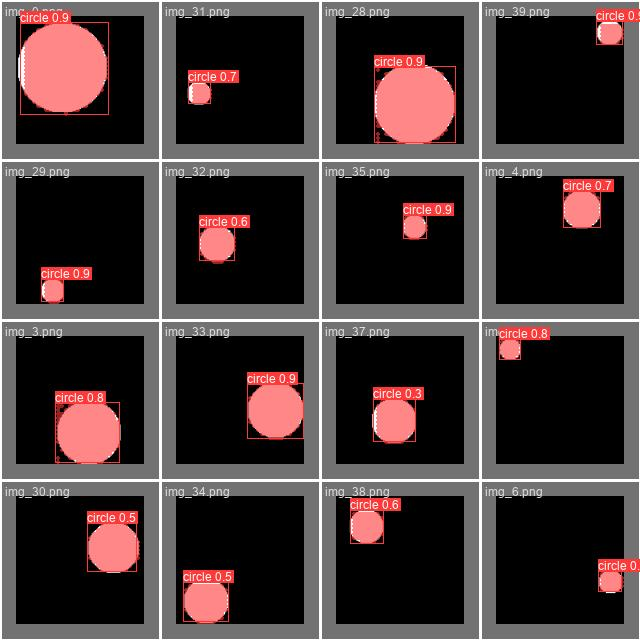

In [8]:
show_image(filename="runs/segment/train/val_batch0_pred.jpg")

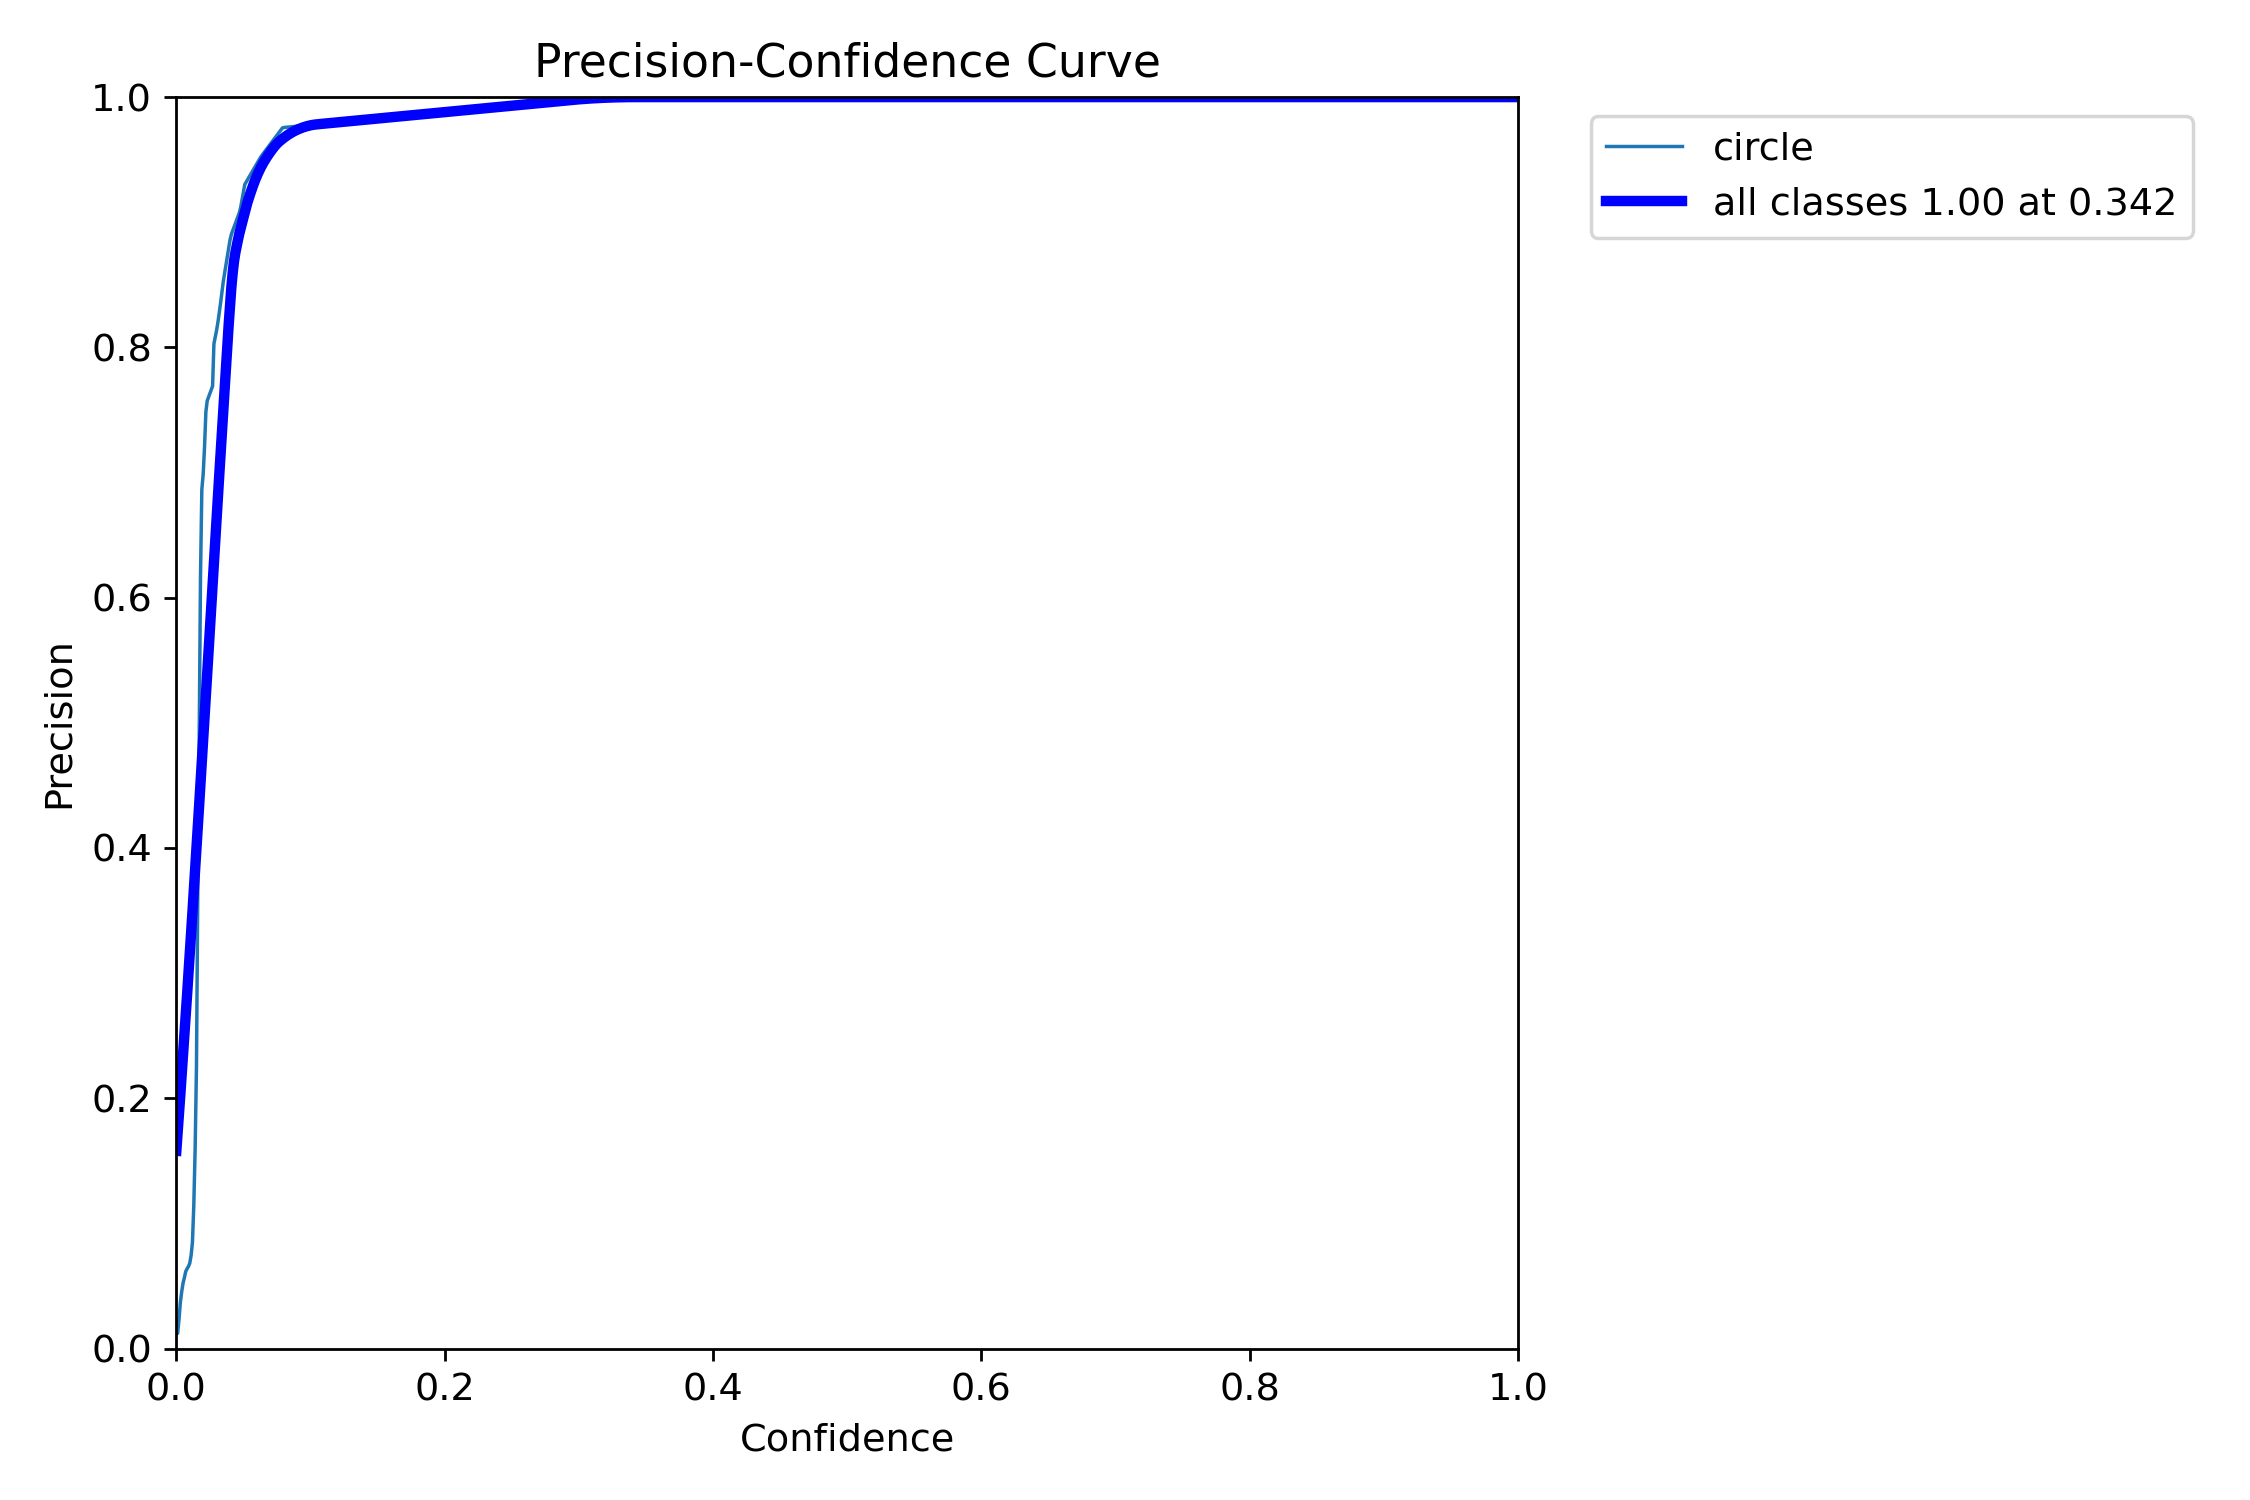

In [9]:
show_image(filename="runs/segment/train/MaskP_curve.png")

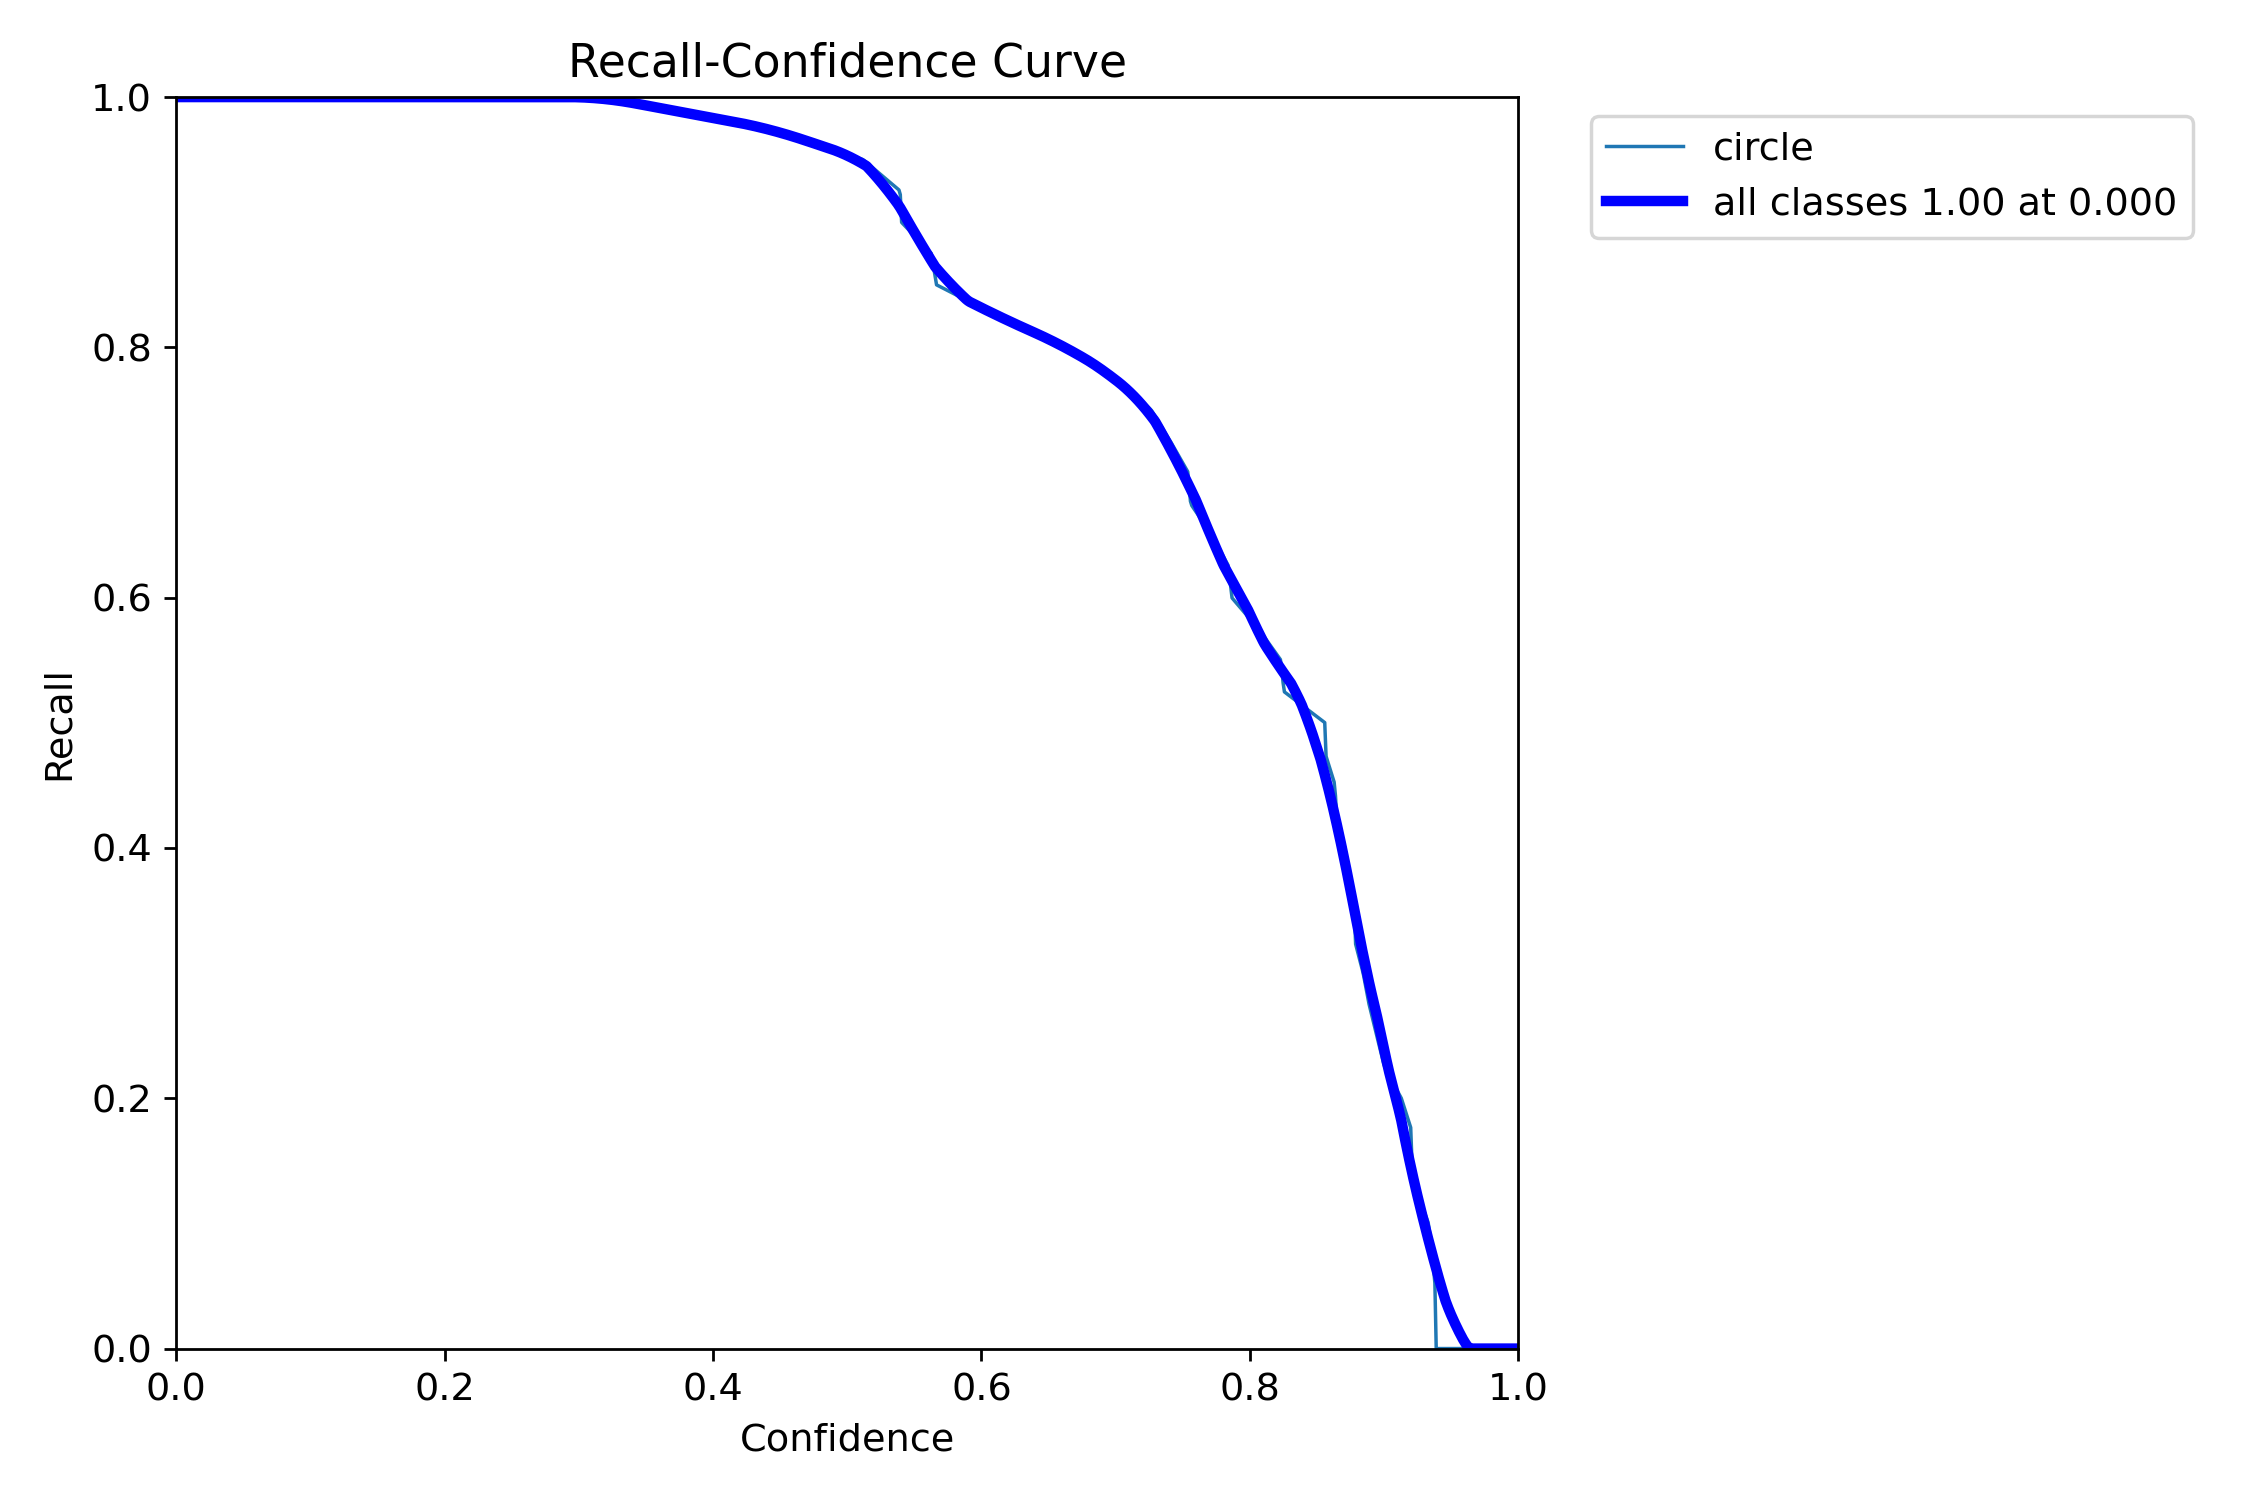

In [10]:
show_image(filename="runs/segment/train/MaskR_curve.png")

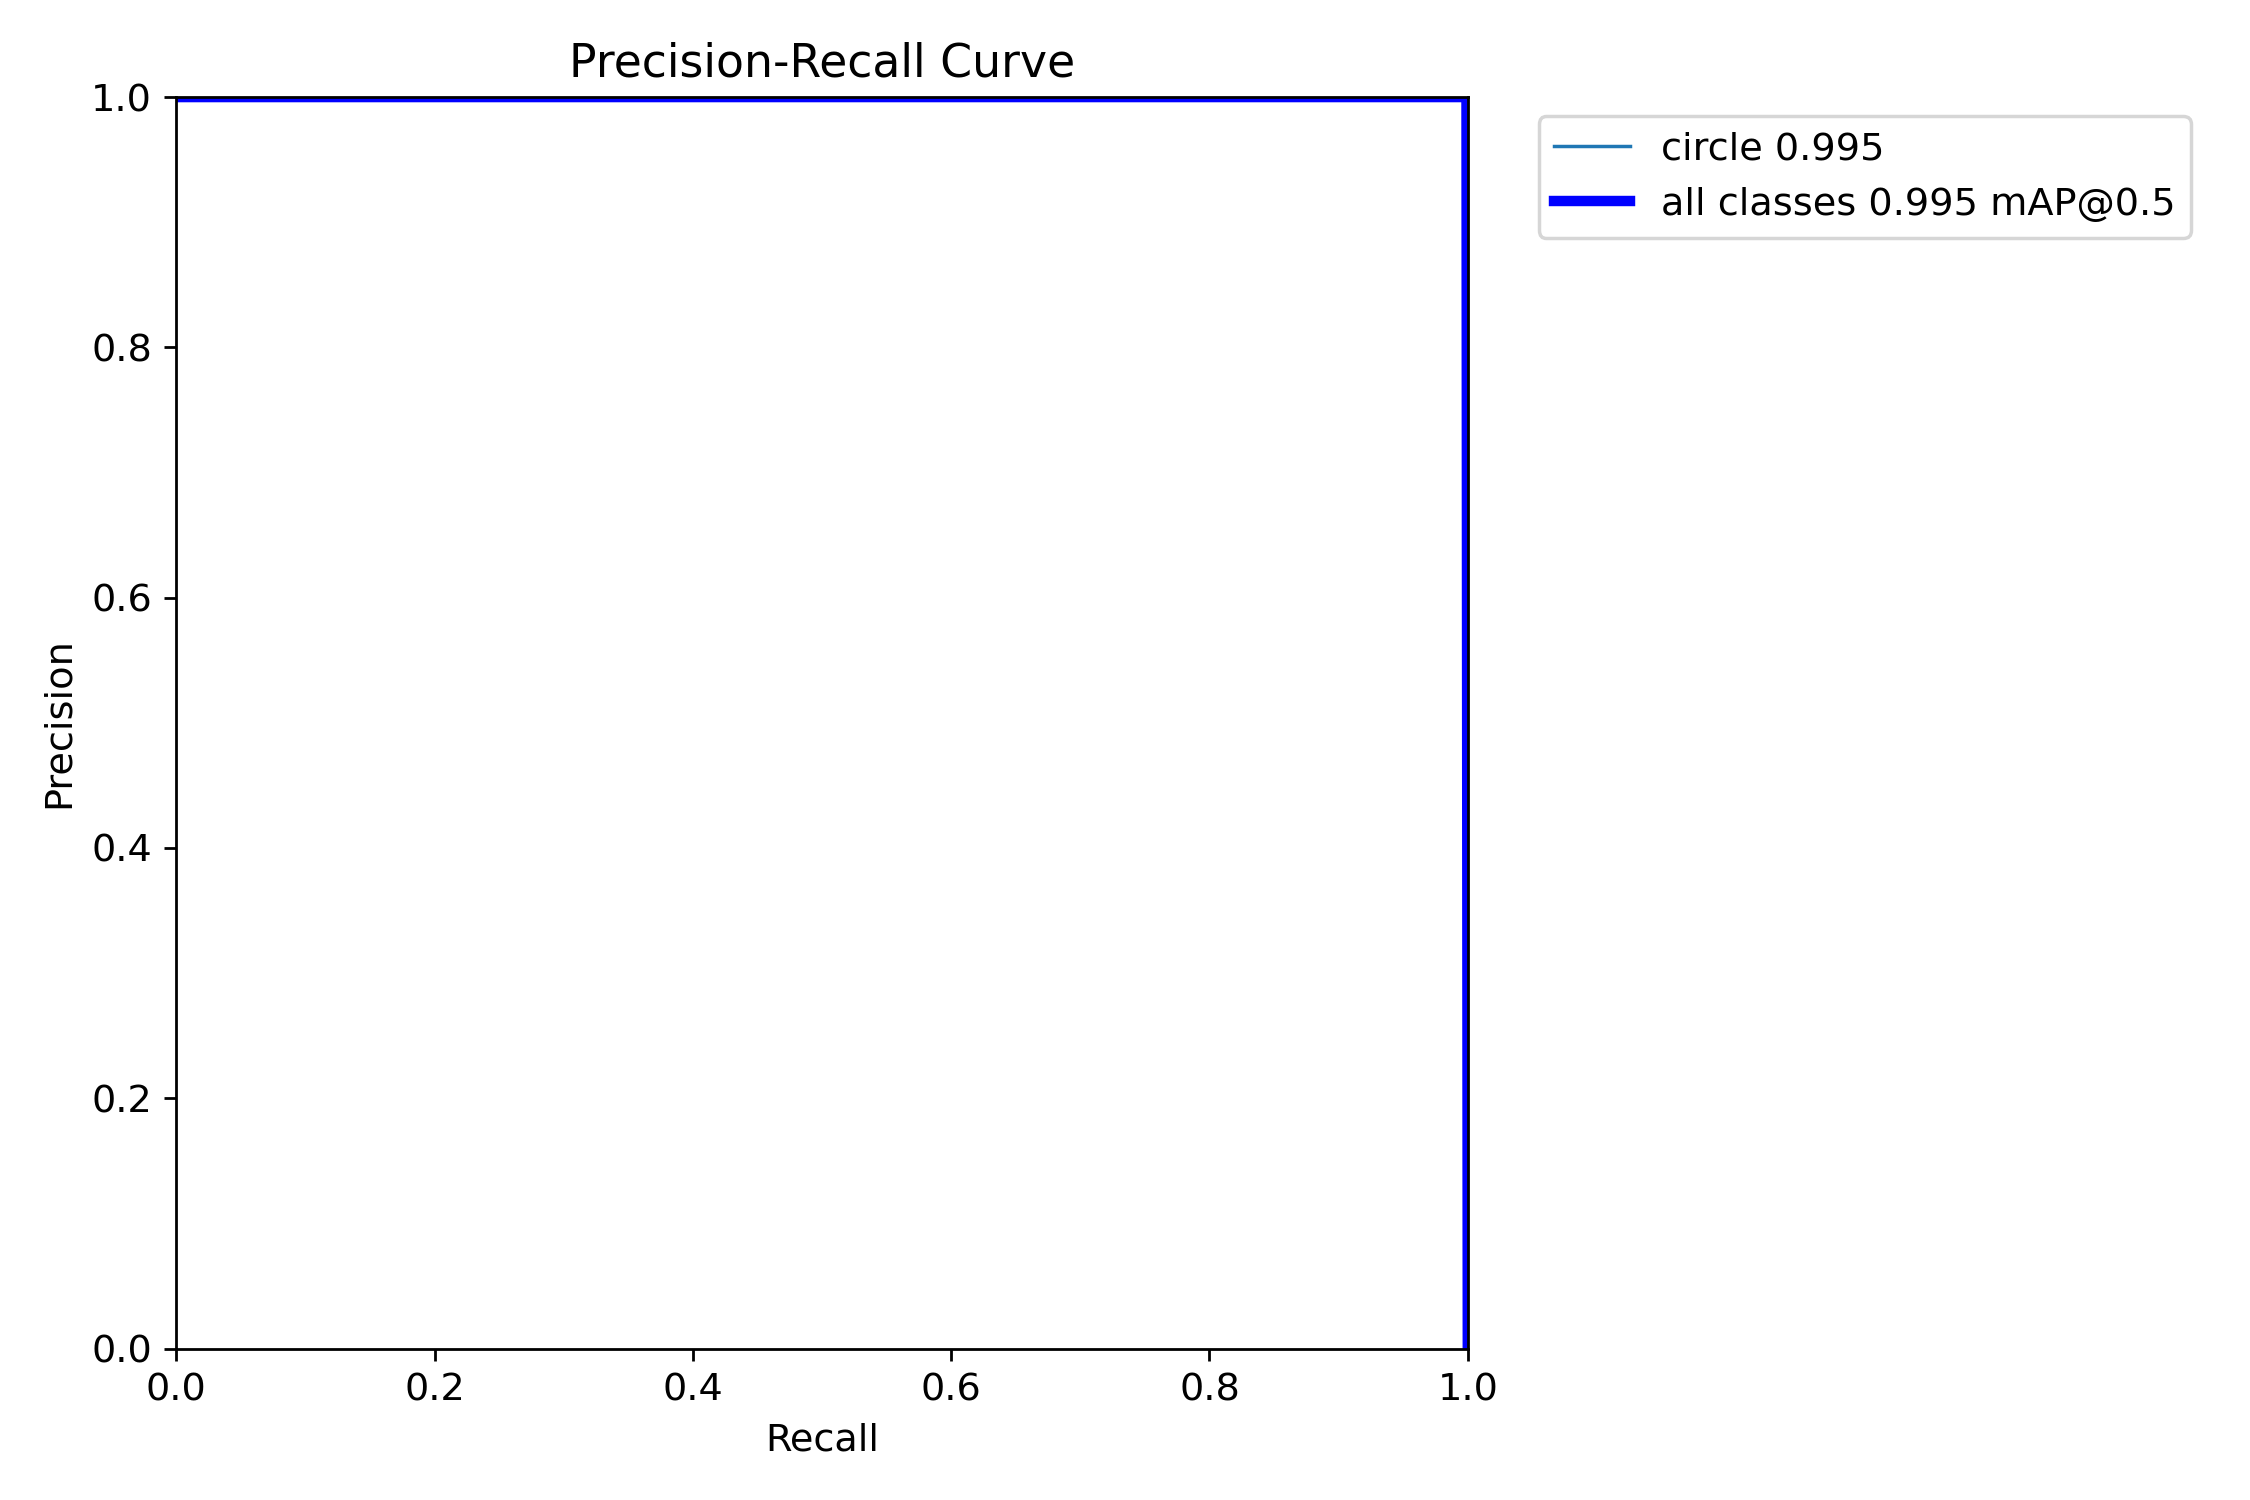

In [11]:
show_image(filename="runs/segment/train/MaskPR_curve.png")

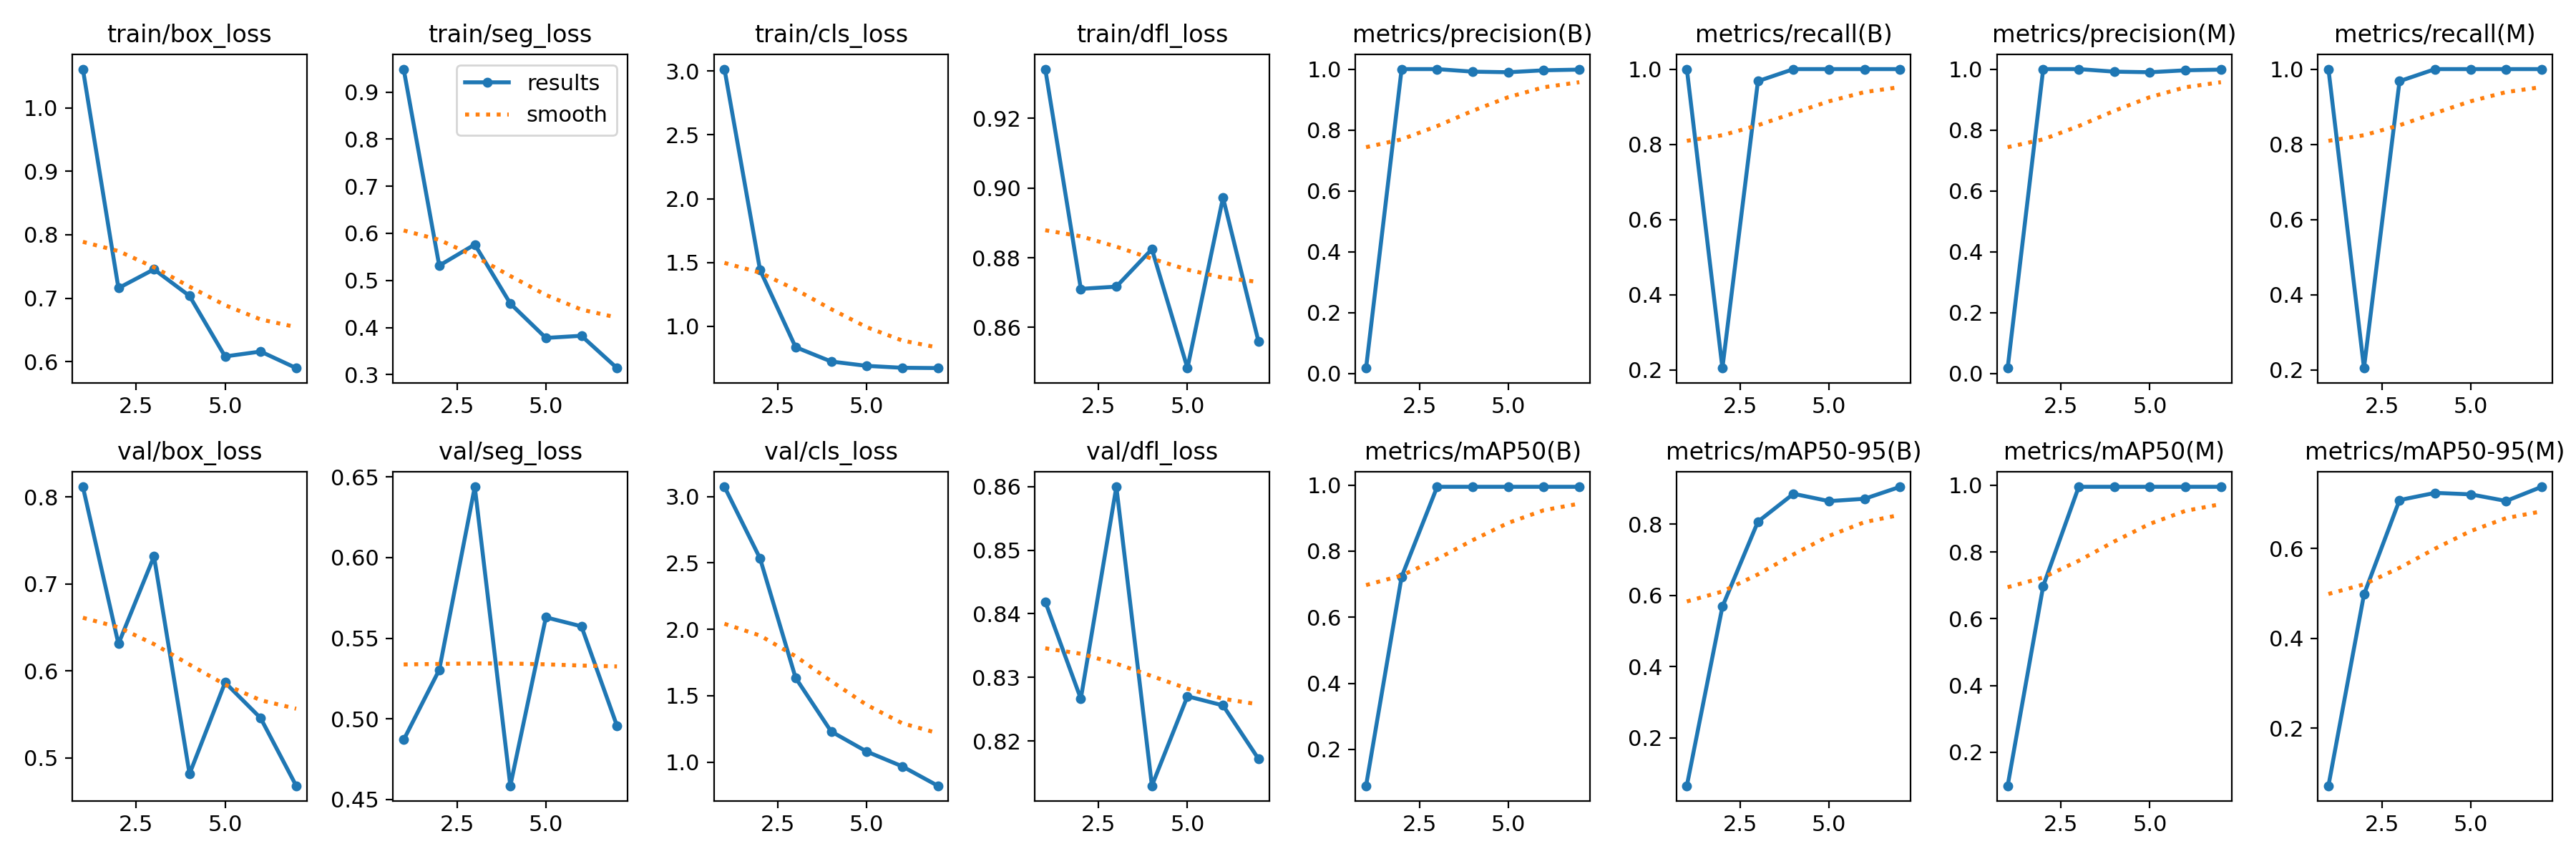

In [12]:
show_image(filename="runs/segment/train/results.png")

In [57]:
my_model = YOLO('runs/segment/train/weights/best.pt')
results = list(my_model('datasets/test/images/img_5.png', conf=0.128))
result = results[0]


image 1/1 e:\硕士文件\TUE\tue-5ARIP10-Q3 Team project\YOLO\ultralytics-main\datasets\test\images\img_5.png: 128x128 1 circle, 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 128)


In [34]:
# This returns the boundary polygon of the object
masks_xy = result.masks.xyn
print("Mask information (pixel coordinates)：", masks_xy)

Mask information (pixel coordinates)： [array([[    0.16406,     0.53125],
       [    0.15625,     0.53906],
       [    0.15625,     0.54688],
       [    0.14062,      0.5625],
       [    0.13281,      0.5625],
       [      0.125,     0.57031],
       [      0.125,     0.57812],
       [    0.10937,     0.59375],
       [    0.10156,     0.59375],
       [    0.09375,     0.60156],
       [    0.09375,     0.79687],
       [    0.10156,     0.80469],
       [    0.10937,     0.80469],
       [      0.125,     0.82031],
       [      0.125,     0.82812],
       [    0.13281,     0.83594],
       [    0.14062,     0.83594],
       [    0.15625,     0.85156],
       [    0.15625,     0.85937],
       [    0.16406,     0.86719],
       [    0.17969,     0.86719],
       [     0.1875,       0.875],
       [    0.19531,       0.875],
       [    0.21094,     0.89062],
       [    0.21875,     0.89062],
       [    0.22656,     0.89844],
       [    0.35937,     0.89844],
       [    0.36

In [56]:
masks_data = result.masks.data
print("Mask data:", masks_data)

Mask data: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


In [55]:
import torchvision.transforms as T
T.ToPILImage()(result.masks.data).show()
original_image = Image.open("datasets/test/images/img_5.png")
original_image.show()